# find regions where trades are within a certain band

In [1]:
import numpy as np
import pandas as pd
import mplfinance as mpf
import os
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
import talib as ta # conda activate cryt310
tickerpair="ETCUSDT"
interval="5m"
intervals=['1m','3m','5m','15m','30m','1h','2h','3h','4h','6h','8h','12h','1d','3d','1w','1Month']
years=sorted(set([g.split("_")[2] for g in glob(f"kline_data\\{tickerpair}/*")]))

In [2]:
%%time
df = [pd.read_csv(g) for g in sorted(glob(f"kline_data\\{tickerpair}/*")) if f"_{interval}.csv" in g]
df = pd.concat(df, ignore_index=True).drop_duplicates().reset_index(drop=True)

dfmpl=df[["open_time","open","high","low","close","volume"]]
dfmpl = dfmpl.rename(columns={"open_time":"Date","open":"Open","high":"High","low":"Low","close":"Close","volume":"Volume"})
dfmpl=dfmpl.set_index("Date")
dfmpl.index = pd.to_datetime(dfmpl.index,unit="ms")
print(len(dfmpl))
dfmpl=dfmpl.iloc[-15000:]

513629
CPU times: total: 1.61 s
Wall time: 1.79 s


In [3]:
len(os.listdir("kline_data")),os.listdir("kline_data")

(250,
 ['1INCHUSDT',
  'AAVEUSDT',
  'ACAUSDT',
  'ACHUSDT',
  'ADAUSDT',
  'ADXUSDT',
  'AGIXUSDT',
  'AGLDUSDT',
  'AKROUSDT',
  'ALGOUSDT',
  'ALICEUSDT',
  'ALPHAUSDT',
  'ALPINEUSDT',
  'AMBUSDT',
  'AMPUSDT',
  'ANKRUSDT',
  'APEUSDT',
  'API3USDT',
  'APTUSDT',
  'ARBUSDT',
  'ARPAUSDT',
  'ARUSDT',
  'ASRUSDT',
  'ASTRUSDT',
  'ATAUSDT',
  'ATOMUSDT',
  'AUDIOUSDT',
  'AUDUSDT',
  'AVAXUSDT',
  'AXSUSDT',
  'BAKEUSDT',
  'BANDUSDT',
  'BATUSDT',
  'BCHUSDT',
  'BELUSDT',
  'BETAUSDT',
  'BETHUSDT',
  'BICOUSDT',
  'BLZUSDT',
  'BNBUSDT',
  'BNXUSDT',
  'BONDUSDT',
  'BSWUSDT',
  'BTCUSDT',
  'BTTCUSDT',
  'BURGERUSDT',
  'BUSDUSDT',
  'C98USDT',
  'CAKEUSDT',
  'CELOUSDT',
  'CELRUSDT',
  'CFXUSDT',
  'CHESSUSDT',
  'CHRUSDT',
  'CHZUSDT',
  'CITYUSDT',
  'CKBUSDT',
  'CLVUSDT',
  'COCOSUSDT',
  'COMPUSDT',
  'COTIUSDT',
  'CRVUSDT',
  'CTKUSDT',
  'CTSIUSDT',
  'DARUSDT',
  'DASHUSDT',
  'DEGOUSDT',
  'DENTUSDT',
  'DFUSDT',
  'DODOUSDT',
  'DOGEUSDT',
  'DOTUSDT',
  'DUSKUSDT

# use the gradient of the std/mean instead

CPU times: total: 594 ms
Wall time: 737 ms


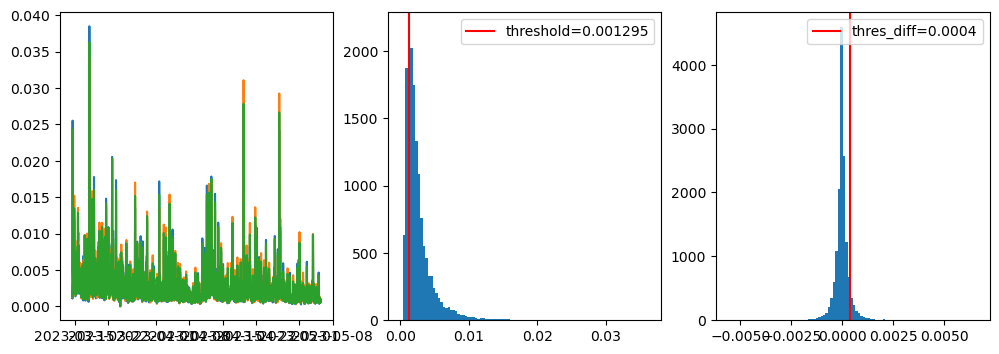

In [4]:
%%time
xvals=np.arange(len(dfmpl.Close))
rolling_high_std_mean = dfmpl.High.rolling(14).std()/dfmpl.High.rolling(14).mean()
rolling_low_std_mean = dfmpl.Low.rolling(14).std()/dfmpl.Low.rolling(14).mean()
rolling_std_mean=rolling_low_std_mean*0.5+rolling_high_std_mean*0.5
r_std_mean_diff = rolling_std_mean.diff()

fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(12,4))
ax1.plot(rolling_high_std_mean)
ax1.plot(rolling_low_std_mean)
ax1.plot(rolling_std_mean)
n,bins,_ = ax2.hist(rolling_std_mean,bins=100)
thres = np.percentile(rolling_std_mean.values[np.where(~np.isnan(rolling_std_mean.values))],25)
ax2.axvline(thres,c="r",label=f"threshold={thres:.4g}")
ax2.legend()
ax3.hist(r_std_mean_diff,bins=100)
thres_diff = np.percentile(r_std_mean_diff.values[np.where(~np.isnan(r_std_mean_diff.values))],98)
thres_diff=0.0004
ax3.axvline(thres_diff,c="r",label=f"thres_diff={thres_diff:.4g}")
ax3.legend()
#thres = 0.001
mkoffset = 1.01
crossings = np.where(np.diff(r_std_mean_diff>thres_diff,1))[0]
scatter = [ dfmpl.Close.iloc[i]*mkoffset if i in crossings else np.nan for i in xvals]
crossup=np.where(np.diff((r_std_mean_diff>thres_diff)*1.,1)>0)[0]
scatterup = [ dfmpl.Close.iloc[i]*mkoffset if i in crossup else np.nan for i in xvals]
crossdn=np.where(np.diff((r_std_mean_diff>thres_diff)*1.,1)<0)[0]
scatterdn = [ dfmpl.Close.iloc[i]*mkoffset if i in crossdn else np.nan for i in xvals]
vlines = [dfmpl.index[i] for i in xvals if i in crossings ]
my_vlines=[i for i in xvals if i in crossings ]

In [5]:
# %%time
# apds = [ 
#     mpf.make_addplot(rolling_std_mean,panel=1,color='b',type='line',ylabel=f"diff(std/mean)>thres{thres_diff:.2g}"), 
#     mpf.make_addplot(scatterup,color='g',type='scatter',marker="^"),
#     mpf.make_addplot(scatterdn,color='r',type='scatter',marker="v"),
#        ]
# fig, axlist =mpf.plot(dfmpl,addplot=apds,ylabel=f"{tickerpair} Price ({interval})",mav=[10,20], 
#          returnfig=True,figsize=(20*1.5,7*1.5),panel_ratios=(1,1),warn_too_much_data=2000)#,figratio=(1,1),figscale=1.5)
# for ax in axlist[:]:
#     for vline in my_vlines:
#         ax.axvline(x=vline, linestyle='--',linewidth=1,alpha=0.3)
# mpf.show()

In [136]:
%%time
predict = []
result= []
profit=[]
trade_durations = []
concated_df0=[]
for entry,exit in zip(np.where(~np.isnan(scatterup))[0],np.where(~np.isnan(scatterdn))[0]):
    #print(entry,exit)
    #print(dfmpl.iloc[entry-1:exit+1])
    s = dfmpl.iloc[entry-1]
    s1 = dfmpl.iloc[entry]
    s2 = dfmpl.iloc[exit]
    predict.append( s.Open-s.Close )
    result.append( s.Close-s2.Close )
    if (s.Open-s.Close)<0: # buy
        gains= (s2.Close-s.Close)/(s.Close)
        profit.append(gains)
        indd=dfmpl.iloc[[entry,exit]].index
        diff = indd[1].to_datetime64()-indd[0].to_datetime64()
        trade_hr = int(diff)*1e-9/3600
        trade_durations.append( trade_hr ) 
    if (s.Open-s.Close)>0: # sell
        gains= -(s2.Close-s.Close)/(s.Close)
        profit.append(gains)
        indd=dfmpl.iloc[[entry,exit]].index
        diff = indd[1].to_datetime64()-indd[0].to_datetime64()
        trade_hr = int(diff)*1e-9/3600
        trade_durations.append( trade_hr ) 
    if (s.Open-s.Close)!=0:
        concated_df0.append( dfmpl.iloc[entry-1:exit+1] )
        #print(dfmpl.iloc[entry-1:exit+1])
        #print("*"*8,s.Close,s2.Close)
concated_df = pd.concat(concated_df0)

CPU times: total: 219 ms
Wall time: 324 ms


C:\Users\aatan\anaconda3\envs\cryt310\lib\site-packages\mplfinance\_arg_validators.py:83: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


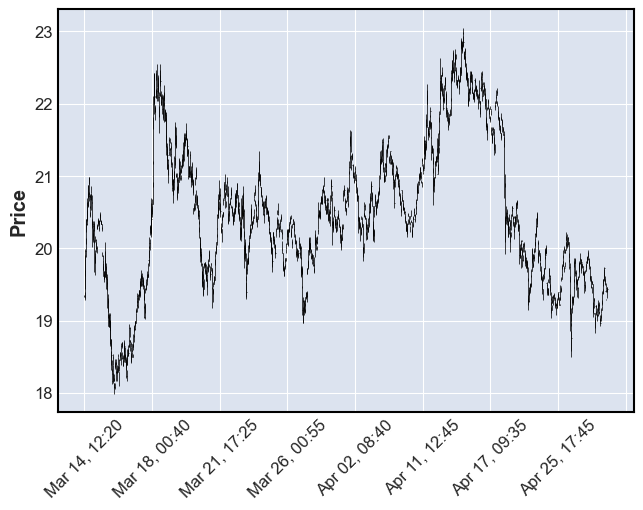

In [137]:
fig, axlist =mpf.plot(concated_df,returnfig=True)

In [122]:
final_profit = 1
profit1=profit[:]
equity=[1]
for p in profit1:
    final_profit *= (1+p)
    equity.append(final_profit)
wins=sum(p>0 for p in profit1)
ind = dfmpl.iloc[np.where(~np.isnan(scatterup))[0][np.r_[0,-1]]].index
diff = ind[1].to_datetime64()-ind[0].to_datetime64()
trading_days = int(diff)*1e-9/3600/24

print(f"percentage gain = {final_profit*100-100:.2f}%")
print(f"trades={len(profit1)}, wins={wins}, win%={wins/len(profit1)*100:.2f}%")
print(f"trading_days= {trading_days:.3g}days, trade duration={np.mean(trade_durations):.3g}hr")

percentage gain = 146.40%
trades=433, wins=293, win%=67.67%
trading_days= 51.6days, trade duration=0.206hr


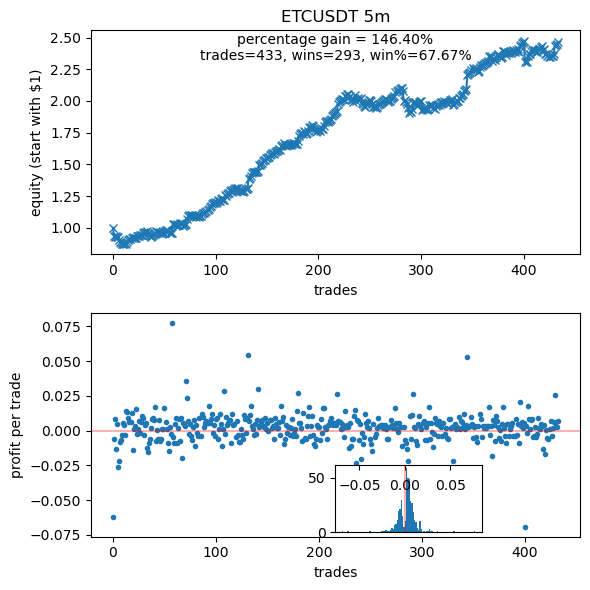

In [123]:
fig,(ax1,ax2)=plt.subplots(2,1,figsize=(6,6))
ax1.plot(equity,"-x")
ax1.set_ylabel("equity (start with $1)")
ax1.set_title(
    f"{tickerpair} {interval}")
ax1.text(0.5,0.99,
    f"percentage gain = {final_profit*100-100:.2f}%"+"\n"+
    f"trades={len(profit1)}, wins={wins}, win%={wins/len(profit1)*100:.2f}%",transform=ax1.transAxes,va="top",ha="center")
ax2.plot(profit,".")
ax2.axhline(0,c="r",alpha=0.3)
ax2.set_ylabel("profit per trade")

for ax in (ax1,ax2):
    ax.set_xlabel("trades")
plt.tight_layout()
ax3 = ax2.inset_axes((0.5,0.02,0.3,0.3))
ax3.hist(profit,bins=100)
ax3.axvline(0,c="r",alpha=0.3)
ax3.tick_params("x",top=True, labeltop=True, bottom=False, labelbottom=False,pad=-20,direction="in")

In [58]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
confusion_matrix(np.sign(result), np.sign(predict))

array([[126,  25,  67],
       [  0,   0,   1],
       [ 72,  32, 167]], dtype=int64)

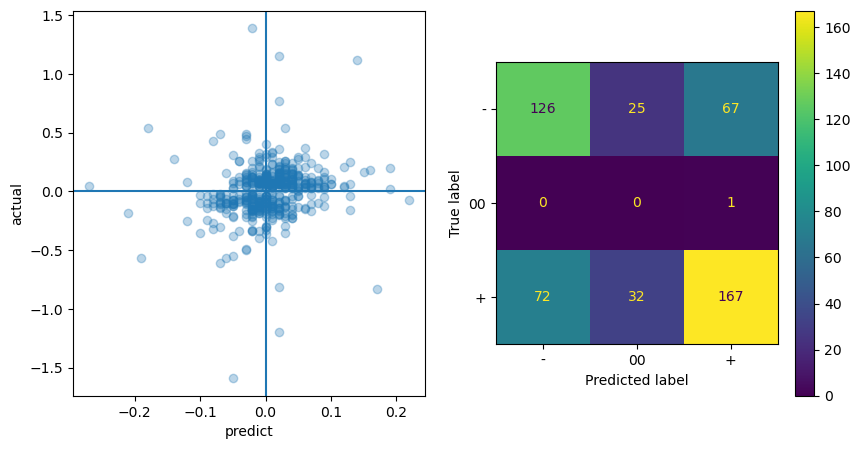

In [59]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))

ax1.scatter(predict,result,alpha=0.3)
ax1.set_xlabel("predict")
ax1.set_ylabel("actual")
ax1.axvline(0)
ax1.axhline(0)

ConfusionMatrixDisplay.from_predictions(
        np.sign(result),
        np.sign(predict),
        display_labels=["-","00","+"],ax=ax2)